In [1]:
import pathlib

from heliostack import Image, ImageSequence
from heliostack.grid import compute_hull, compute_stack_rates

import torch

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import Angle
from astropy import units as u

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from sklearn.cluster import DBSCAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

def stack(sequence: ImageSequence):
    psi = torch.zeros(2500, 5000, device=device, dtype=dtype)
    phi = torch.zeros(2500, 5000, device=device, dtype=dtype)

    for im in sequence.images:
        dx, dy = im.image.shape
        psi[0:dx, 0:dy] += im.image
        phi[0:dx, 0:dy] += im.weight

    s = psi / torch.sqrt(phi)
    return s

def extract(s, threshold=2.0, min_area=3):

    ys, xs = torch.where(s > threshold)
    if len(xs) == 0:
        return [], []
    points = np.array([xs.cpu().numpy(), ys.cpu().numpy()]).T
    clustering = DBSCAN(eps=1, min_samples=min_area, algorithm='ball_tree').fit(points)
    keep = clustering.labels_ > 0
    unique_labels = set(clustering.labels_[keep])
    xs = xs[keep]
    ys = ys[keep]
    points = points[keep]

    x_c = []
    y_c = []
    snr = []
    for k in unique_labels:
        class_member_mask = (clustering.labels_[keep] == k)
        x, y = np.mean(xs[class_member_mask].tolist()), np.mean(ys[class_member_mask].tolist())
        x_c.append(x)
        y_c.append(y)

    return x_c, y_c

def median_reference_index(epochs):
    return np.where(epochs == np.percentile(epochs, 50, interpolation='nearest'))[0][0]


### Read in all of the images

In [2]:
def ingest_image(image_path, weight_path, device, dtype) -> Image:
    im = fits.open(image_path)
    wt = fits.open(weight_path)

    wcs = WCS(im[1].header)
    epoch = Time(im[1].header['MJD-OBS'], format='mjd', scale='utc')

    image = Image(im[1].data, 
                  wt[1].data, 
                  wcs, 
                  epoch, 
                  device=device,
                  dtype=dtype)
    return image

In [26]:
#root = '/nfs/deep/diffim_distant/B1d/20201019/CCD1'
root = '/Users/kjnapier/Desktop/research/data/jts/B1a/20201018/CCD5/'

image_paths = list(pathlib.Path(root).glob('*.diff.rescale.fits.fz'))[:]
weight_paths = list(pathlib.Path(root).glob('*.diff.weight.fits.fz'))[:]
assert len(image_paths) == len(weight_paths)

# read in the images
images = []
for i, w in zip(image_paths, weight_paths):
    images.append(ingest_image(i, w, device, dtype))
sequence = ImageSequence(images)

In [59]:
reference_index = median_reference_index(sequence.epochs.numpy())
ra = Angle(sequence.images[reference_index].ra, u.rad)
dec = Angle(sequence.images[reference_index].dec, u.rad)
epoch = Time(sequence.epochs.numpy()[reference_index], format='jd', scale='utc')
duration = (sequence.epochs.max() - sequence.epochs.min()) * u.day

In [60]:
hull = compute_hull(ra, dec, epoch, rmin=10, rmax=100, imin=0, imax=90)
ra_rates, dec_rates = compute_stack_rates(hull, 1, duration)

In [66]:
ras = []
decs = []
for ra_rate, dec_rate in zip(ra_rates, dec_rates):
    s, wcs = sequence.stack(ra_rate, dec_rate, reference_epoch=reference_index, EDGE_CUT_PIXELS=250, pixel_scale=0.27)
    x, y = extract(s, threshold=1.2, min_area=2)
    # for xx, yy in zip(x, y):
    #     fig, ax = plt.subplots(figsize=(2, 2))
    #     xx = int(xx)
    #     yy = int(yy)
    #     ax.imshow(s[yy-25:yy+26, xx-25:xx+26].cpu().numpy(), origin='lower')
    ra, dec = wcs.all_pix2world(x, y, 0)
    ras.extend(ra)
    decs.extend(dec)

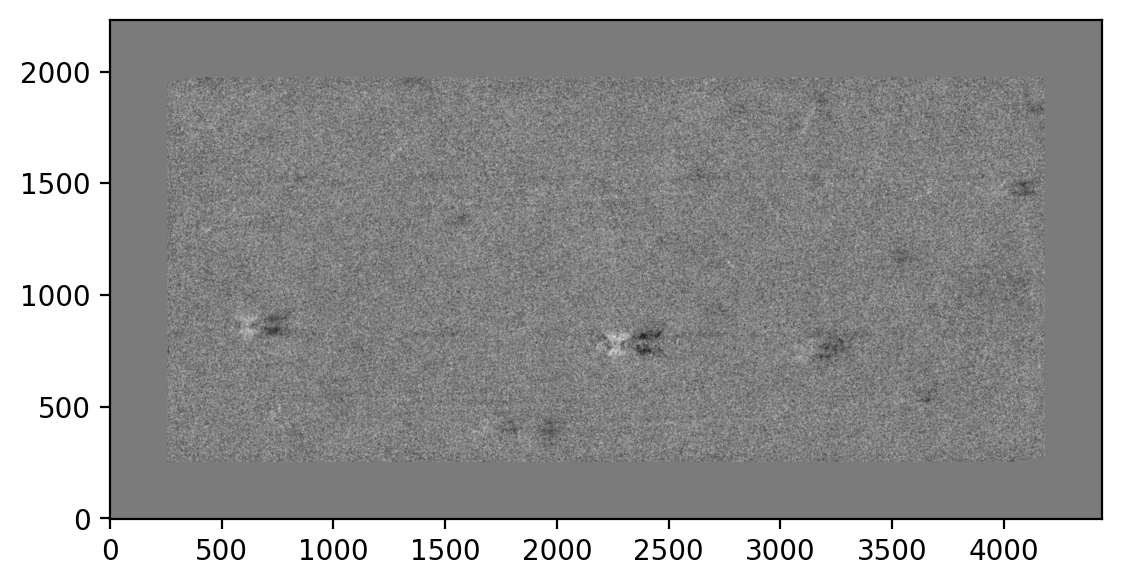

In [67]:
plt.imshow(s.cpu().numpy(), origin='lower', cmap='gray')

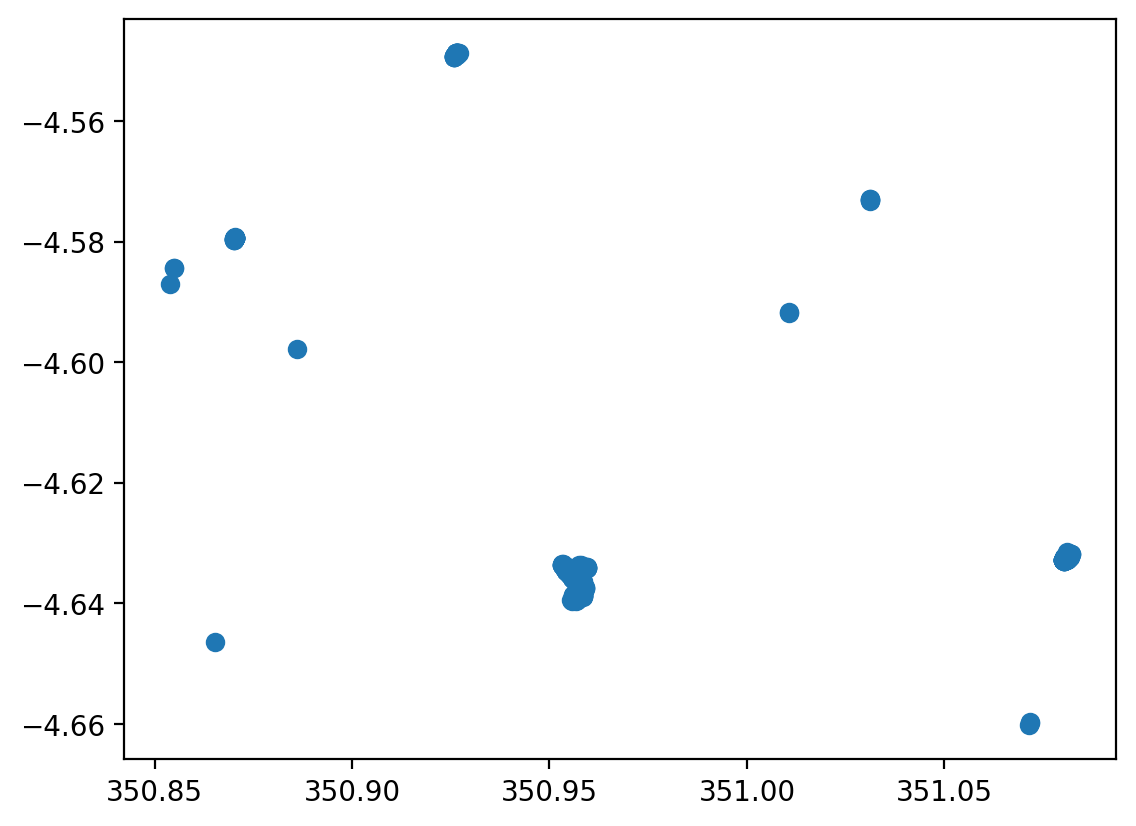

In [68]:
plt.scatter(ras, decs)

In [49]:
N = 3
M = int(np.ceil(len(xs) / N))
fig, ax = plt.subplots(M, N, figsize=(10, M * 1))
for idx, (x, y) in enumerate(zip(xs, ys)):
    
    x = int(x)
    y = int(y)
        
    #ax.imshow(s[y-25:y+26, x-25:x+26].cpu().numpy(), origin='lower')
    ax[idx // N, idx % N].imshow(s[y-25:y+26, x-25:x+26].cpu().numpy(), origin='lower')

for i in range(M):
    for j in range(N):
        ax[i, j].axis('off')

NameError: name 'xs' is not defined

### Calculate the stack rates

In [224]:
# use the grid

CPU times: user 150 ms, sys: 8.94 ms, total: 159 ms
Wall time: 158 ms


### Stack at each rate, and extract sources

In [203]:
%%time
for _ in range(1):
    s = stack(images)
    sources = sep.extract(np.float32(s.cpu().numpy()), 2, minarea=2)

CPU times: user 2.82 s, sys: 46 ms, total: 2.86 s
Wall time: 576 ms


In [206]:
import pandas as pd

In [207]:
pd.DataFrame(sources)

,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,...,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
0,2.0,3,3,557,558,16,17,557.721237,16.706332,0.201054,...,4.677608,9.142162,18.695312,3.908905,12.710938,558,17,558,17,0
1,2.0,7,3,3060,3062,153,155,3061.374202,153.972228,0.378621,...,0.032778,31.370739,39.508301,7.386112,21.687500,3061,154,3061,154,0
2,2.0,4,3,1477,1478,391,393,1477.745599,392.000720,0.189681,...,-0.004755,11.018188,19.075195,3.738708,10.367188,1478,392,1478,392,0
3,2.0,3,2,3542,3543,464,465,3542.761174,464.321604,0.181788,...,-4.549904,9.054855,19.768555,3.980240,13.250000,3543,464,3543,464,0
4,2.0,2,2,1340,1340,523,524,1340.000000,523.505310,0.083333,...,-0.000000,4.051941,10.113281,2.047485,6.175781,1340,524,1340,523,8
5,2.0,4,4,461,462,547,548,461.488802,547.514085,0.249875,...,0.011489,9.093761,18.710938,2.393093,5.656250,461,548,461,548,0
6,2.0,2,2,1400,1401,574,574,1400.469077,574.000000,0.332377,...,-0.000000,4.926517,10.945312,2.615601,6.871094,1400,574,1400,574,8
7,2.0,4,4,1966,1967,573,574,1966.559358,573.493016,0.246477,...,0.027680,17.393009,31.710938,4.947235,12.351562,1967,573,1967,573,0
8,2.0,2,2,1599,1599,662,663,1599.000000,662.497415,0.083333,...,-0.000000,6.153000,15.984375,3.092407,8.023438,1599,662,1599,663,8
9,2.0,8,3,2399,2401,906,908,2399.807997,906.958918,0.470117,...,0.657519,41.651703,48.765762,10.095613,33.656250,2400,907,2400,907,0
